## Backscatter Coefficients
Comparing Monte Carlo to Heinrich's tabulation

In [1]:
using NeXLCore
using DataFrames
using CSV
using Gadfly
using ThreadsX

In [2]:
Threads.nthreads()

1

In [3]:
"""
     backscatter(elm::Element, e0, traj=10000)

Compute the backscatter coefficient using a Monte Carlo algorithm using the Browning1994 transport algorithm.
"""
function backscatter(elm::Element, e0, traj=10000)
  traj2::Function=(t::Electron, mat::Material)->NeXLCore.transport(t, mat, Browning1994)
  sample = bulk(pure(elm))
  count = ThreadsX.sum(Base.OneTo(traj)) do i
    bs = false
    trajectory(gun(Electron, e0, 1.0e-6), sample, traj2) do _, reg
      bs = reg==sample # The final region is the chamber...
    end
    bs ? 1 : 0
  end
  return count/traj
end

backscatter (generic function with 2 methods)

In [4]:
using BenchmarkTools
@btime backscatter(n"C",20.0e3)
@btime backscatter(n"Al",20.0e3)
@btime backscatter(n"Fe",20.0e3)
@btime backscatter(n"U",20.0e3)

  3.428 s (91809084 allocations: 2.93 GiB)


  5.376 s (146370846 allocations: 4.67 GiB)

  6.525 s (173957634 allocations: 5.55 GiB)


  5.102 s (138445422 allocations: 4.42 GiB)


0.5509

Load a set of measured backscatter coefficients for comparison.

In [5]:
hr=CSV.read(joinpath(@__DIR__,"..","data","HeinrichBackscatterCoefficients.csv"), DataFrame)

Row,Z,10 keV,20 keV,30 keV,40 keV,49 keV
,Int64,Float64?,Float64?,Float64,Float64?,Float64?
1,6,0.069,0.06,0.052,0.054,0.052
2,12,0.145,0.14,0.136,0.132,0.13
3,13,missing,missing,0.149,missing,missing
4,14,0.174,0.164,0.159,0.153,0.15
5,22,0.262,0.253,0.243,0.245,0.243
6,24,0.273,0.268,0.265,0.259,0.256
7,25,0.292,0.286,0.284,0.277,0.276
8,26,0.289,0.287,0.275,0.276,0.282
9,27,0.309,0.302,0.302,0.297,0.292


In [15]:
ntraj=16000 # Nominally > 10k for decent precision
for e0 in (10.0e3, 20.0e3, 30.0e3, 40.0e3, 49.0e3)
    hr[:,"MC[$(e0/1000.0) keV]"] = [ backscatter(elements[z], e0, ntraj) for z in hr[:,"Z"] ]
end
hr

Row,Z,10 keV,20 keV,30 keV,40 keV,49 keV,MC[10 keV],MC[20 keV],MC[30 keV],MC[40 keV],MC[49 keV],MC[10.0 keV],MC[20.0 keV],MC[30.0 keV],MC[40.0 keV],MC[49.0 keV]
,Int64,Float64?,Float64?,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,6,0.069,0.06,0.052,0.054,0.052,0.061,0.046,0.0584,0.062,0.046,0.065875,0.06325,0.06,0.0578125,0.054375
2,12,0.145,0.14,0.136,0.132,0.13,0.204,0.21,0.1982,0.181,0.196,0.207313,0.200187,0.205125,0.197375,0.189062
3,13,missing,missing,0.149,missing,missing,0.218,0.244,0.2123,0.19,0.203,0.22775,0.218062,0.212188,0.214312,0.212938
4,14,0.174,0.164,0.159,0.153,0.15,0.246,0.228,0.2284,0.244,0.236,0.240687,0.2335,0.232625,0.23475,0.230375
5,22,0.262,0.253,0.243,0.245,0.243,0.343,0.353,0.3361,0.343,0.348,0.345125,0.344813,0.343687,0.34475,0.339813
6,24,0.273,0.268,0.265,0.259,0.256,0.382,0.36,0.3743,0.359,0.36,0.36525,0.36575,0.371063,0.367063,0.367437
7,25,0.292,0.286,0.284,0.277,0.276,0.379,0.365,0.3817,0.373,0.379,0.374125,0.373812,0.380812,0.370188,0.371875
8,26,0.289,0.287,0.275,0.276,0.282,0.367,0.372,0.3783,0.428,0.4,0.386437,0.389313,0.395813,0.38925,0.37975
9,27,0.309,0.302,0.302,0.297,0.292,0.413,0.374,0.4067,0.379,0.42,0.392062,0.391625,0.395688,0.400562,0.394875


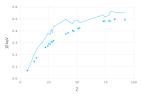

In [16]:
plot(
  layer(hr, x="Z", y="10 keV", Geom.point),
  layer(hr, x="Z", y="MC[10 keV]", Geom.line)
)

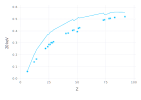

In [17]:
hr[:,"MC[20 keV]"]=[ backscatter(elements[z], 20.0e3, ntraj) for z in hr[:,"Z"] ]
plot(
  layer(hr, x="Z", y="20 keV", Geom.point),
  layer(hr, x="Z", y="MC[20 keV]", Geom.line)
)

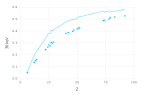

In [18]:
plot(
  layer(hr, x="Z", y="30 keV", Geom.point),
  layer(hr, x="Z", y="MC[30 keV]", Geom.line)
)

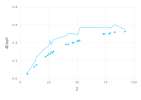

In [19]:
plot(
  layer(hr, x="Z", y="40 keV", Geom.point),
  layer(hr, x="Z", y="MC[40 keV]", Geom.line)
)

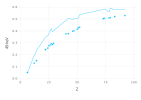

In [20]:
plot(
  layer(hr, x="Z", y="49 keV", Geom.point),
  layer(hr, x="Z", y="MC[49 keV]", Geom.line)
)

Not great!  Curiously `Browning1991` looks better.